# Importing Libraries and Data

In [7]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV
from imblearn.over_sampling import RandomOverSampler
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, roc_curve, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier
import joblib
import warnings
warnings.filterwarnings('ignore')

churn = pd.read_csv("Churn_Modelling.csv")
churn = churn.dropna().drop_duplicates().drop(["RowNumber", "CustomerId", "Surname", "Geography"], axis = 1)

# Pre-processing

In [8]:
# Train/test split
X = churn.drop("Exited", axis = 1)
y = churn["Exited"]
X_train1, X_test, y_train1, y_test = train_test_split(X, y, test_size = 0.25, random_state = 20, stratify=churn['Exited'])

# Handling Imbalanced Classes
ros = RandomOverSampler(random_state=20)
X_train, y_train = ros.fit_resample(X_train1, y_train1)

# Creating Validation Folds
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=20)

num_vars = ['CreditScore', 'Age', 'Tenure', 'Balance', 'EstimatedSalary']
cat_vars = ['Gender', 'HasCrCard', 'IsActiveMember']

# Pre-processing
numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_vars),
        ('cat', categorical_transformer, cat_vars)
    ])

# Training Model

In [9]:
rf_spec = RandomForestClassifier(random_state=20)

rf_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('rf', rf_spec)
])

rf_param_grid = {
    'rf__n_estimators': [50, 100, 200],  # Number of trees in the forest
    'rf__max_depth': [None, 10, 20, 30],  # Maximum depth of trees
    'rf__min_samples_split': [2, 5, 10],  # Minimum samples required to split an internal node
    'rf__min_samples_leaf': [1, 2, 4],    # Minimum samples required to be at a leaf node
    'rf__max_features': ['auto', 'sqrt', 'log2'],  # Number of features to consider for best split
    'rf__bootstrap': [True, False]  # Whether bootstrap samples are used when building trees
}

rf_grid_search = GridSearchCV(
    rf_pipeline,
   rf_param_grid,
    cv=cv,
    n_jobs=-1,
    scoring='roc_auc'
)

rf_grid_search.fit(X_train, y_train)

best_model = rf_grid_search.best_estimator_
joblib.dump(best_model, 'final_rf_model.pkl')
rf_best_model = joblib.load('final_rf_model.pkl')
y_pred_rf = rf_best_model.predict(X_test)

# Confusion Matrix

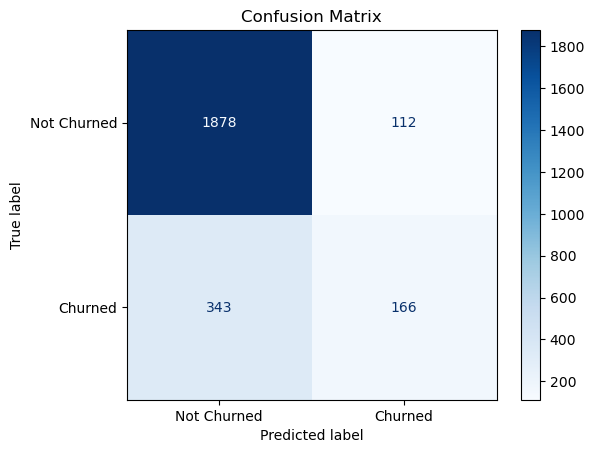

In [10]:
cm = confusion_matrix(y_test, y_pred_rf)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Not Churned', 'Churned'])
disp.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix")
plt.show()

# AUC

In [11]:
roc_auc_score(y_test, y_pred_rf)

0.634924129488306

# Accuracy

In [13]:
accuracy_score(y_test, y_pred_rf)

0.8179271708683473